### <span style="color: pink;"> Importing Libraries </span>

In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
import os
from scipy.sparse import csr_matrix
import scipy.sparse as sp
import itertools
from sklearn.neighbors import NearestNeighbors
import pickle
from rapidfuzz import process,fuzz

%matplotlib inline

### <span style="color: pink;"> Importing Data </span>

In [2]:
movies = pd.read_csv(r"C:/Users/Mandula Thrimanne/OneDrive/Documents/Personal/Medium Articles/Movie Recommendation System/Raw Data/ml-latest-small/movies.csv")
ratings = pd.read_csv(r"C:/Users/Mandula Thrimanne/OneDrive/Documents/Personal/Medium Articles/Movie Recommendation System/Raw Data/ml-latest-small/ratings.csv")

In [3]:
# getting a glimpse of the data

movies.head()


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
# getting a glimpse of the data

ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
ratings['userId'].nunique()

610

In [6]:
# debug attempt: how many unique movies are there

ratings['movieId'].nunique()

9724

### <span style="color: pink;"> Cleaning the movies data </span>

In [7]:
# checking the deformity in movie titles
movies[movies['title'].str.contains(', The \(')]

,movieId,title,genres
10,11,"American President, The (1995)",Comedy|Drama|Romance
28,29,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi
46,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
49,54,"Big Green, The (1995)",Children|Comedy
52,58,"Postman, The (Postino, Il) (1994)",Comedy|Drama|Romance
...,...,...,...
8741,127180,"Story of Film: An Odyssey, The (2011)",Documentary
8808,130578,"Gunman, The (2015)",Action|Thriller
9018,140523,"Visit, The (2015)",Comedy|Horror
9120,145935,"Peanuts Movie, The (2015)",Adventure|Animation|Children|Comedy


In [8]:
# fixing the titles of movies to keep it consistent with the rest of the movies

movies['title'] = movies['title'].str.replace(', The', '')

### <span style="color: pink;"> Tranform the dataframe into a pivot table </span>


In [9]:
# creating the pivot table

final_dataset = ratings.pivot_table(index='movieId',columns='userId',values='rating',fill_value=0)
final_dataset.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4,0.0,0.0,0,4,0,4.5,0,0,0.0,...,4.0,0,4,3,4.0,2.5,4,2.5,3,5.0
2,0,0.0,0.0,0,0,4,0.0,4,0,0.0,...,0.0,4,0,5,3.5,0.0,0,2.0,0,0.0
3,4,0.0,0.0,0,0,5,0.0,0,0,0.0,...,0.0,0,0,0,0.0,0.0,0,2.0,0,0.0
4,0,0.0,0.0,0,0,3,0.0,0,0,0.0,...,0.0,0,0,0,0.0,0.0,0,0.0,0,0.0
5,0,0.0,0.0,0,0,5,0.0,0,0,0.0,...,0.0,0,0,3,0.0,0.0,0,0.0,0,0.0


In [10]:
final_dataset.shape

(9724, 610)

In [11]:
no_user_voted = ratings.groupby('movieId')['rating'].agg('count')
no_movies_voted = ratings.groupby('userId')['rating'].agg('count')

In [12]:
print(no_user_voted)

movieId
1         215
2         110
3          52
4           7
5          49
         ... 
193581      1
193583      1
193585      1
193587      1
193609      1
Name: rating, Length: 9724, dtype: int64


### <span style="color: pink;"> Removing noise from the data </span>

In [13]:
# Calculate the count of non-zero values for each row and column
movie_rating_counts = final_dataset.astype(bool).sum(axis=1)
user_rating_counts = final_dataset.astype(bool).sum(axis=0)

print(f"Movies were rated by {movie_rating_counts.median()} users as the median")
print(f"Users rated {user_rating_counts.median()} movies as the median")

print(f"Movies were rated by {movie_rating_counts.mean()} users as the mean")
print(f"Users rated {user_rating_counts.mean()} movies as the mean")

Movies were rated by 3.0 users as the median
Users rated 70.5 movies as the median
Movies were rated by 10.369806663924312 users as the mean
Users rated 165.30491803278687 movies as the mean


In [14]:
print(movie_rating_counts)

movieId
1         215
2         110
3          52
4           7
5          49
         ... 
193581      1
193583      1
193585      1
193587      1
193609      1
Length: 9724, dtype: int64


In [15]:
# Filter rows and columns based on the median values we found from above
filtered_movies = movie_rating_counts[movie_rating_counts > 10].index
filtered_users = user_rating_counts[user_rating_counts > 30].index

# Select only the rows and columns that meet the condition
final_dataset_filtered = final_dataset.loc[filtered_movies,:]
final_dataset_filtered=final_dataset_filtered.loc[:,filtered_users]


# Output the resulting pivot table
final_dataset_filtered.shape


(2121, 498)

In [16]:
print(final_dataset_filtered)

userId   1    3    4    5    6    7    8    9    10   11   ...  601  602  603  \
movieId                                                    ...                  
1          4  0.0    0    4    0  4.5    0    0  0.0    0  ...  4.0    0    4   
2          0  0.0    0    0    4  0.0    4    0  0.0    0  ...  0.0    4    0   
3          4  0.0    0    0    5  0.0    0    0  0.0    0  ...  0.0    0    0   
5          0  0.0    0    0    5  0.0    0    0  0.0    0  ...  0.0    0    0   
6          4  0.0    0    0    4  0.0    0    0  0.0    5  ...  0.0    3    4   
...      ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
174055     0  0.0    0    0    0  0.0    0    0  0.0    0  ...  4.0    0    0   
176371     0  0.0    0    0    0  0.0    0    0  0.0    0  ...  4.0    0    0   
177765     0  0.0    0    0    0  0.0    0    0  0.0    0  ...  4.5    0    0   
179819     0  0.0    0    0    0  0.0    0    0  0.0    0  ...  0.0    0    0   
187593     0  0.0    0    0 

In [17]:
# export a copy to be used in the server

# final_dataset_filtered.to_csv('final_dataset_filtered.csv')

In [18]:
final_dataset_filtered

userId,1,3,4,5,6,7,8,9,10,11,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4,0.0,0,4,0,4.5,0,0,0.0,0,...,4.0,0,4,3,4.0,2.5,4,2.5,3,5.0
2,0,0.0,0,0,4,0.0,4,0,0.0,0,...,0.0,4,0,5,3.5,0.0,0,2.0,0,0.0
3,4,0.0,0,0,5,0.0,0,0,0.0,0,...,0.0,0,0,0,0.0,0.0,0,2.0,0,0.0
5,0,0.0,0,0,5,0.0,0,0,0.0,0,...,0.0,0,0,3,0.0,0.0,0,0.0,0,0.0
6,4,0.0,0,0,4,0.0,0,0,0.0,5,...,0.0,3,4,3,0.0,0.0,0,0.0,0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174055,0,0.0,0,0,0,0.0,0,0,0.0,0,...,4.0,0,0,0,0.0,0.0,0,0.0,0,0.0
176371,0,0.0,0,0,0,0.0,0,0,0.0,0,...,4.0,0,0,0,0.0,0.0,0,0.0,0,0.0
177765,0,0.0,0,0,0,0.0,0,0,0.0,0,...,4.5,0,0,0,0.0,0.0,0,0.0,0,0.0


### <span style="color: pink;"> Converting the ratings df to a sparse matrix </span>

In [19]:
csr_data = csr_matrix(final_dataset_filtered.values)
final_dataset_filtered.reset_index(inplace=True)


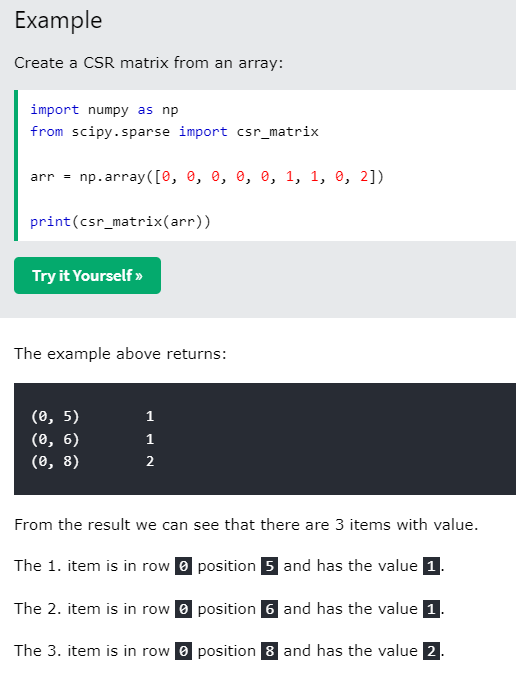

In [20]:
# final_dataset_filtered.to_excel('final_dataset_test.xlsx',index=False)

In [21]:
# print(csr_data)

In [ ]:
# giving the new index a more intiutive name


# Rename the index from 'userId' to 'csr_index'
final_dataset_filtered.index.name = 'csr_index'

final_dataset_filtered

userId,movieId,1,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
csr_index,,,,,,,,,,,,,,,,,,,,,
0,1,4,0.0,0,4,0,4.5,0,0,0.0,...,4.0,0,4,3,4.0,2.5,4,2.5,3,5.0
1,2,0,0.0,0,0,4,0.0,4,0,0.0,...,0.0,4,0,5,3.5,0.0,0,2.0,0,0.0
2,3,4,0.0,0,0,5,0.0,0,0,0.0,...,0.0,0,0,0,0.0,0.0,0,2.0,0,0.0
3,5,0,0.0,0,0,5,0.0,0,0,0.0,...,0.0,0,0,3,0.0,0.0,0,0.0,0,0.0
4,6,4,0.0,0,0,4,0.0,0,0,0.0,...,0.0,3,4,3,0.0,0.0,0,0.0,0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2116,174055,0,0.0,0,0,0,0.0,0,0,0.0,...,4.0,0,0,0,0.0,0.0,0,0.0,0,0.0
2117,176371,0,0.0,0,0,0,0.0,0,0,0.0,...,4.0,0,0,0,0.0,0.0,0,0.0,0,0.0
2118,177765,0,0.0,0,0,0,0.0,0,0,0.0,...,4.5,0,0,0,0.0,0.0,0,0.0,0,0.0


In [23]:
# print(csr_data)

### <span style="color: pink;"> Building the movie recommendation system using KNN </span>

#### **Description:**

- NearestNeighbors: This is a class from the scikit-learn library used for unsupervised neighbor-based learning. It computes nearest neighbors for input data points based on a specified distance metric.
- metric='cosine': This parameter specifies the distance metric to be used. In this case, it's cosine similarity, which measures the cosine of the angle between two vectors.
- algorithm='brute': This parameter specifies the algorithm used to compute nearest neighbors. 'brute' algorithm computes distances between all pairs of points in the dataset.
- n_neighbors=11: This parameter sets the number of neighbors to consider when making predictions. Here, it's set to 11, meaning it will consider the 11 nearest neighbors.
- n_jobs=-1: This parameter specifies the number of parallel jobs to run for neighbors search. Setting it to -1 utilizes all available CPU cores.
- knn.fit(csr_data): This line fits the k-nearest neighbors model to the data. csr_data is the input data in compressed sparse row format (commonly used for large sparse matrices), and the model is trained to find nearest neighbors based on the specified parameters.

In [24]:
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=11, n_jobs=-1)
knn.fit(csr_data)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=11)

In [25]:
# !pip install rapidfuzz

In [26]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [27]:
def get_movie_recommendation(movie_name):
    
    # number of movies to recommend
    n_movies_to_recommend = 10
    
    # create a list of movies that contains the input text in its titles
    # movie_list = movies[movies['title'].str.contains(movie_name)] 
    
    # Get a list of matches sorted by similarity score
    matches = process.extract(movie_name, movies['title'], scorer=fuzz.ratio)

    # Convert matches to a DataFrame
    matches_df = pd.DataFrame(matches, columns=['title', 'similarity', 'index'])

    # Sort matches by similarity score
    matches_df = matches_df.sort_values(by='similarity', ascending=False)
    

    # Extract the top title
    top_title = matches_df['title'][0]
    

    # Filter the movies DataFrame
    movie_list = movies[movies['title'] == top_title]
    

    # print(movie_list)
    
    # if there are any movies 
    if len(movie_list):        
        
        # take the movieId of the first movie of the list created above
        movie_idx= movie_list.iloc[0]['movieId']
        # print(movie_idx)
 
        
        # take the actual movie id and then map it back to the new index (csr_index) the movie got when you converted the pivot to a csr matrix
        movie_new_idx = final_dataset_filtered[final_dataset_filtered['movieId'] == movie_idx].index[0]
        # print(movie_new_idx)

        # distances variable stores the distance between the input movie and its nearest neighbors
        # indices stores the indices of the nearest neigbors in the the movie_idx list
        # we put +1 here so that we end up with 10 movies since the movie itself will be the closest to the input movie
        distances , indices = knn.kneighbors(csr_data[movie_new_idx],n_neighbors=n_movies_to_recommend+1)   
        
        
        # .squeeze().tolist() removes single-dimensional entries and converts the array to a Python list
        # zip function combines the elements of indices and distances into tuples
        # Converts the zipped tuples into a list of tuples.
        # Sorts the list of tuples based on the second element of each tuple, which is the distance
        # Slices the sorted list in order, excluding the first element (which would be the movie itself as the closest neighbor) and order the remaining elements in ascending order
        
        rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),key=lambda x: x[1])[0:]
        
        recommend_frame = []
        recommend_frame_dict = {}
        
        # looping through the closest neigbors from the above list
        for val in rec_movie_indices:
            
            # retrieves the originL movie ID of recommended movies from final_dataset_filtered based on its "new" index in the dataset
            movie_idx = final_dataset_filtered.iloc[val[0]]['movieId']

            # find the title from the original 'movies' dataset using the original movie id we found above
            # recommend_frame.append({'Title':movies[movies['movieId']==movie_idx]['title'].values[0],'Distance':"{:.3f}".format(val[1])})
            
            # dictionary
            title = movies[movies['movieId']==movie_idx]['title'].values[0]
            distance = "{:.3f}".format(val[1])
            
            recommend_frame_dict[title] = distance
            
        # df = pd.DataFrame(recommend_frame,index=range(1,n_movies_to_reccomend+1))
        
        return recommend_frame_dict
    else:
        return "No movies found. Please check your input"

In [28]:
get_movie_recommendation("big short")

{'Big Short (2015)': '0.000',
 'The Nice Guys (2016)': '0.405',
 'Spotlight (2015)': '0.456',
 'Sicario (2015)': '0.474',
 'Blade Runner 2049 (2017)': '0.475',
 'Hot Tub Time Machine (2010)': '0.482',
 'The Hateful Eight (2015)': '0.483',
 'Wolf of Wall Street (2013)': '0.489',
 'Mad Max: Fury Road (2015)': '0.495',
 'Grand Budapest Hotel (2014)': '0.499',
 'Arrival (2016)': '0.514'}

In [29]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [30]:
bjhbk

NameError: name 'bjhbk' is not defined

### <span style="color: pink;"> Creating a dataset of movies with atleast 10 recommendations  </span>

In [ ]:
# creating a temporary dictionary to append data
temp_dict = {
    'Movie ID':[],
    'Movie Name':[],
    'Recommendations':[]
}

In [ ]:
# testing out the loop
test_movie_list = movies['title'][0:10]
# print(test_movie_list[2])
get_movie_recommendation(test_movie_list[2])
for movie in test_movie_list:
    # print(movie)
    try:
        print(len(get_movie_recommendation(movie)))
    except:
        print("No Recommendations")

In [ ]:
# running through the actual loop

movie_id_list = movies['movieId']
movie_list = movies['title']

In [ ]:
len(temp_dict['Movie ID'])

In [ ]:
len(temp_dict['Movie Name'])

In [ ]:
len(temp_dict['Recommendations'])

In [ ]:
count = 0
for movie,movie_id in zip(movie_list,movie_id_list):
    count += 1
    # print(f"We are checking movie #{count}")
    try:
        temp_dict['Recommendations'].append(len(get_movie_recommendation(movie)))
        temp_dict['Movie ID'].append(movie_id)
        temp_dict['Movie Name'].append(movie)
    except:
        temp_dict['Recommendations'].append("NA")
        temp_dict['Movie ID'].append(movie_id)
        temp_dict['Movie Name'].append(movie)

    if count % 100 == 0:
        df = pd.DataFrame(data=temp_dict)
        df.to_excel('valid_movies_w_recommendations.xlsx', index=False)
        print("We are printing........")
    else:
        pass

In [ ]:
df = pd.DataFrame(data=temp_dict)
# df.to_excel('valid_movies_w_recommendations.xlsx', index=False)

### <span style="color: pink;"> Extracting the years from movies</span>

In [ ]:
import re

df['Year'] = df['Movie Name'].map(lambda x: re.search(r'\b\d{4}\b', x).group() if re.search(r'\b\d{4}\b', x) else None)


In [ ]:
df['Year'].head()

In [ ]:
# df.to_excel('valid_movies_w_recommendations_v2.xlsx', index=False)

### <span style="color: pink;"> Exporting a Pickle file of the KNN model</span>

In [ ]:
# Assuming knn is your NearestNeighbors model
# with open('Saved Model/knn_model.pkl', 'wb') as f:
#     pickle.dump(knn, f)


## <span style="color: red;"> Create a content based model to make this a hybrid model </span>